In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
import os

# Control vs Patient: ALL

In [2]:
# model tuning parameters
n_splits = 5
criterion = 'accuracy'

In [3]:
df = pd.read_csv('../../data/final_dataset.csv')

In [4]:
df['Diagnosis'].unique()

array(['Bipolar II', 'Major Depressive Disorder', 'Bipolar I', 'Control',
       'MDD'], dtype=object)

In [5]:
df['Group'] = df['Diagnosis']
df['Group'] = df['Group'].replace('Bipolar I',1)
df['Group'] = df['Group'].replace('Bipolar II',1)
df['Group'] = df['Group'].replace('MDD',1)
df['Group'] = df['Group'].replace('Major Depressive Disorder',1)
df['Group'] = df['Group'].replace('Control',0)
df.columns

Index(['Unnamed: 0', 'Watch Status', 'Phone Brand', 'Diagnosis', 'Gender',
       'Study ID', 'LAMP ID', 'Race', 'Age', 'DOB', 'Date of Consent',
       'gps_data_quality_mean', 'gps_data_quality_var', 'hometime_mean',
       'hometime_var', 'entropy_mean', 'entropy_var', 'screen_duration_mean',
       'screen_duration_var', 'internal_sleep_mean', 'internal_sleep_var',
       'PHQ-2_mean', 'PHQ-2_var', 'GAD-2_mean', 'GAD-2_var', 'Group'],
      dtype='object')

In [6]:
# predictor and target vars
X = df[['gps_data_quality_mean', 'gps_data_quality_var', 'GAD-2_mean', 'GAD-2_var', 'GAD-2_mean', 'PHQ-2_var',
  'hometime_mean', 'hometime_var', 'entropy_mean',
       'entropy_var', 'internal_sleep_mean', 'internal_sleep_var', 'screen_duration_mean',
     'screen_duration_var']]
y = df['Group']

In [7]:
pct_imputed = (X.isnull().sum().sum())/(np.shape(X)[0]*np.shape(X)[1])
print("We have imputed %0.1f percent of the data" % (pct_imputed * 100))

We have imputed 13.8 percent of the data


In [8]:
# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=0)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [9]:
# standardize
scale_train = StandardScaler()
scale_test = StandardScaler()

X_train = scale_train.fit_transform(X_train)
X_test = scale_test.fit_transform(X_test)

In [10]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [11]:
accuracy, precision, recall, auc = {}, {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(y_test, predictions)
    precision[key] = precision_score(y_test, predictions)
    recall[key] = recall_score(y_test, predictions)
    auc[key] = roc_auc_score(y_test, predictions)

In [12]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['AUC'] = auc.values()

In [13]:
df_model

,Accuracy,Precision,Recall,AUC
Logistic Regression,0.846154,0.862069,0.925926,0.796296
Support Vector Machines,0.769231,0.800000,0.888889,0.694444
Decision Trees,0.769231,0.846154,0.814815,0.740741
Random Forest,0.871795,0.866667,0.962963,0.814815
Naive Bayes,0.846154,0.838710,0.962963,0.773148
K-Nearest Neighbor,0.846154,0.838710,0.962963,0.773148


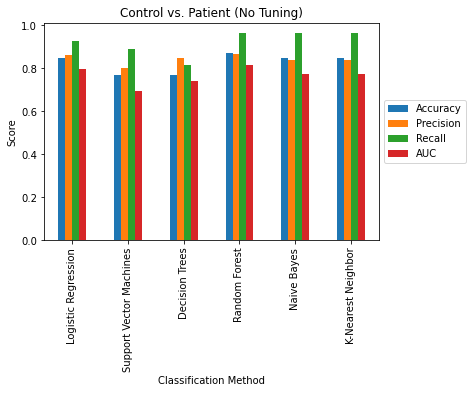

In [14]:
df_model.plot(kind="bar")
plt.title("Control vs. Patient (No Tuning)")
plt.xlabel("Classification Method")
plt.ylabel("Score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Logistic Regression

In [15]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
params = grid_search.best_params_

Best: 0.778571 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.708333 (0.149783) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.708333 (0.149783) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.716667 (0.155246) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.741667 (0.168131) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.741667 (0.168131) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.741667 (0.168131) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.758333 (0.148385) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.758333 (0.148385) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.725000 (0.172615) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.778571 (0.095565) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.778571 (0.095565) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.697619 (0.186772) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.717857 (0.048445) wit

In [16]:
# instantiate the model (using tuned params)
logreg_tuned = LogisticRegression(C=params['C'], penalty=params['penalty'], solver=params['solver'])

# fit the model with data
logreg_tuned.fit(X_train, y_train)

y_pred = logreg_tuned.predict(X_test)

In [17]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 5,  7],
       [ 0, 27]])

Text(0.5, 257.44, 'Predicted label')

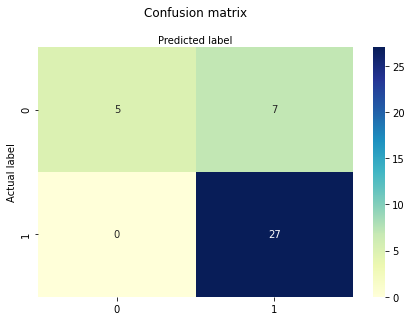

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [19]:
print(f'Logistic Regression Model Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Logistic Regression Model Acccuracy (Tuned Using Optimal Params): 0.8205128205128205


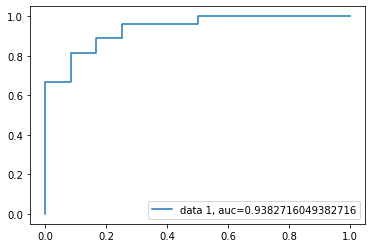

In [20]:
y_pred_proba = logreg_tuned.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Support Vector Machines

In [21]:
# define model and parameters
model = LinearSVC()
penalty = ['l2']
loss=['squared_hinge']
dual=[True, False]
C = [10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(penalty=penalty, loss=loss, dual=dual, C=C)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.741667 using {'C': 1.0, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.698810 (0.153594) with: {'C': 10, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.698810 (0.153594) with: {'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.741667 (0.168131) with: {'C': 1.0, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.741667 (0.168131) with: {'C': 1.0, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.705952 (0.180450) with: {'C': 0.1, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.705952 (0.180450) with: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.689286 (0.181383) with: {'C': 0.01, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.689286 (0.181383) with: {'C': 0.01, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}


In [22]:
params = grid_search.best_params_

In [23]:
linSVC_tuned = LinearSVC(C=params['C'], dual=params['dual'], loss=params['loss'])

In [24]:
# fit the model with data
linSVC_tuned.fit(X_train, y_train)

y_pred = linSVC_tuned.predict(X_test)

In [25]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 6,  6],
       [ 3, 24]])

In [26]:
print(f'Linear SVM Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Linear SVM Acccuracy (Tuned Using Optimal Params): 0.7692307692307693


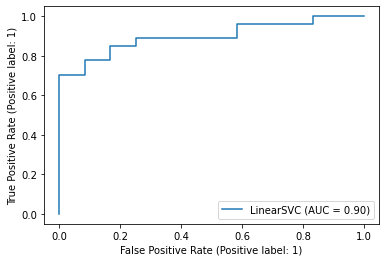

In [27]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(linSVC_tuned,X_test,y_test)

Text(0.5, 257.44, 'Predicted label')

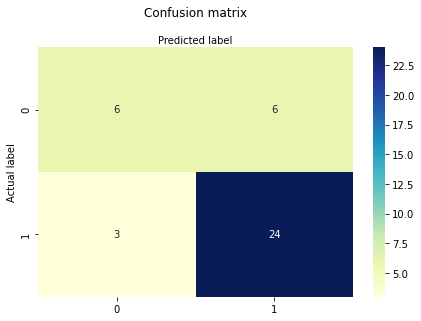

In [28]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



## Decision Trees

In [29]:
model = DecisionTreeClassifier()
splitter = ['best', 'random']
min_samples_split = range(1, 5) #41
min_samples_leaf = range(1, 5) #21
max_features = [None, 'auto', 'sqrt', 'log2']
presort = [True, False]
# define grid search
grid = dict(splitter=splitter, min_samples_split=min_samples_split, 
            min_samples_leaf=min_samples_leaf,
            max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.861905 using {'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 3, 'splitter': 'best'}
0.000000 (0.000000) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 1, 'splitter': 'best'}
0.000000 (0.000000) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 1, 'splitter': 'random'}
0.828571 (0.147369) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
0.784524 (0.139616) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
0.834524 (0.133067) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}
0.828571 (0.119131) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}
0.794048 (0.184412) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
0.801190 (0.123867) with: {'max_features': None, 'min_samples_leaf': 1,

In [30]:
params = grid_search.best_params_

In [31]:
# instantiate the model (using tuned params)
decTree_tuned = DecisionTreeClassifier(max_features=params['max_features'], 
                                       min_samples_leaf=params['min_samples_leaf'], 
                                       min_samples_split=params['min_samples_split'],
                                      splitter=params['splitter'])



# fit the model with data
decTree_tuned.fit(X_train, y_train)

y_pred = decTree_tuned.predict(X_test)
y_pred_proba = decTree_tuned.predict_proba(X_test)

In [32]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 7,  5],
       [ 5, 22]])

In [33]:
print(f'Decision Trees Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Decision Trees Acccuracy (Tuned Using Optimal Params): 0.7435897435897436


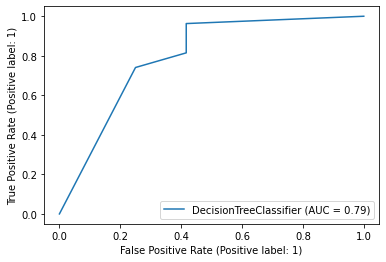

In [34]:
plot_roc_curve(decTree_tuned,X_test,y_test)

Text(0.5, 257.44, 'Predicted label')

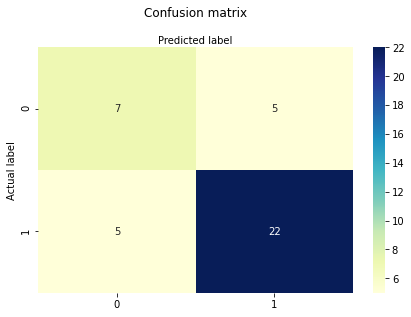

In [35]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Random Forest

In [36]:
model = RandomForestClassifier()

max_depth= [80, 90, 100, 110]
max_features = [2, 3]
min_samples_leaf = [3, 4, 5]
min_samples_split = [8, 10, 12]
n_estimators = [100, 200, 300, 1000]
# define grid search
grid = dict(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf,
           min_samples_split=min_samples_split, n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.888095 using {'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
0.854762 (0.135662) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
0.863095 (0.124688) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
0.854762 (0.119321) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}
0.854762 (0.119321) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}
0.863095 (0.116033) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
0.863095 (0.106679) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
0.854762 (0.119321) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3

In [37]:
params = grid_search.best_params_


In [38]:
# instantiate the model (using tuned params)
ranForest_tuned = RandomForestClassifier(max_features=params['max_features'],
                                         min_samples_leaf=params['min_samples_leaf'], 
                                         min_samples_split=params['min_samples_split'],
                                     max_depth=params['max_depth'], n_estimators=params['n_estimators'])

# fit the model with data
ranForest_tuned.fit(X_train, y_train)

y_pred = ranForest_tuned.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 7,  5],
       [ 1, 26]])

In [39]:
print(f'Random Forest Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Random Forest Acccuracy (Tuned Using Optimal Params): 0.8461538461538461


In [40]:
roc_auc_score(y_test, y_pred)

0.773148148148148

Text(0.5, 257.44, 'Predicted label')

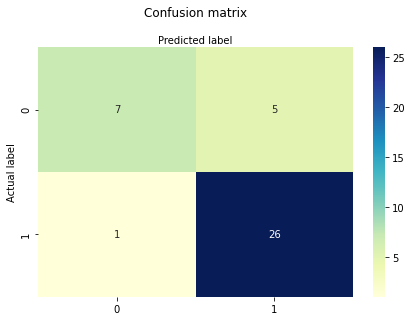

In [41]:

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



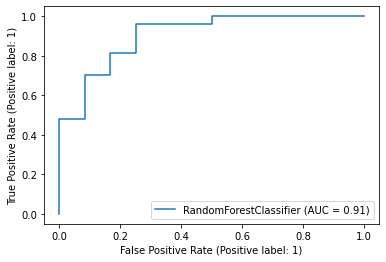

In [42]:
from sklearn.metrics import plot_roc_curve


plot_roc_curve(ranForest_tuned,X_test,y_test)

## Naive Bayes

In [43]:
model = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)


grid_search = GridSearchCV(estimator=model, 
                           param_grid=params_NB, cv=cv, scoring=criterion, error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.801190 using {'var_smoothing': 0.008111308307896872}
0.698810 (0.172746) with: {'var_smoothing': 1.0}
0.715476 (0.170841) with: {'var_smoothing': 0.8111308307896871}
0.715476 (0.170841) with: {'var_smoothing': 0.657933224657568}
0.723810 (0.156474) with: {'var_smoothing': 0.533669923120631}
0.733333 (0.151167) with: {'var_smoothing': 0.43287612810830584}
0.725000 (0.160091) with: {'var_smoothing': 0.3511191734215131}
0.715476 (0.164630) with: {'var_smoothing': 0.2848035868435802}
0.741667 (0.161817) with: {'var_smoothing': 0.23101297000831597}
0.758333 (0.168131) with: {'var_smoothing': 0.1873817422860384}
0.766667 (0.176592) with: {'var_smoothing': 0.15199110829529336}
0.776190 (0.169516) with: {'var_smoothing': 0.12328467394420659}
0.776190 (0.169516) with: {'var_smoothing': 0.1}
0.784524 (0.177073) with: {'var_smoothing': 0.08111308307896872}
0.784524 (0.177073) with: {'var_smoothing': 0.0657933224657568}
0.784524 (0.177073) with: {'var_smoothing': 0.0533669923120631}
0.7845

In [44]:
params = grid_search.best_params_

In [45]:
nb_tuned = GaussianNB(var_smoothing =  params['var_smoothing'])
# fit the model with data
nb_tuned.fit(X_train, y_train)

y_pred = nb_tuned.predict(X_test)
y_pred_proba = nb_tuned.predict_proba(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 7,  5],
       [ 1, 26]])

In [46]:
print(f'Gaussian Naive Bayes Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Gaussian Naive Bayes Acccuracy (Tuned Using Optimal Params): 0.8461538461538461


In [47]:
roc_auc_score(y_test, [x[1] for x in y_pred_proba])

0.95679012345679

Text(0.5, 257.44, 'Predicted label')

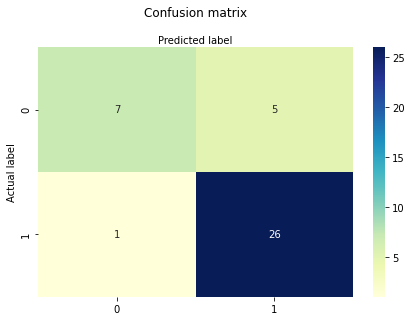

In [48]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



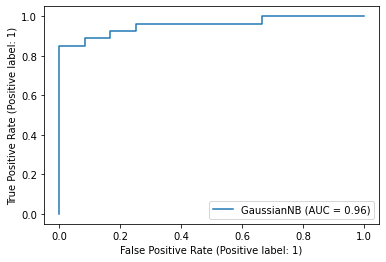

In [49]:
plot_roc_curve(nb_tuned,X_test,y_test)

## KNN Classifier

In [50]:
model = KNeighborsClassifier()

leaf_size = list(range(1,10))
n_neighbors = list(range(1,10))
p=[1,2]

# define grid search
grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.785714 using {'leaf_size': 1, 'n_neighbors': 7, 'p': 2}
0.779762 (0.116216) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 1}
0.720238 (0.119464) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
0.658333 (0.150519) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 1}
0.623810 (0.177073) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 2}
0.785714 (0.143154) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 1}
0.726190 (0.113252) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 2}
0.682143 (0.166905) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 1}
0.717857 (0.154331) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 2}
0.783333 (0.161817) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 1}
0.726190 (0.089563) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 2}
0.725000 (0.139209) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 1}
0.723810 (0.142539) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 2}
0.766667 (0.144112) with: {'leaf_size': 1, 'n_neighbors': 7, 'p': 1}
0.785714 (0.135683) with: {'leaf_size':

In [51]:
params = grid_search.best_params_

In [52]:
knn_tuned = KNeighborsClassifier(leaf_size=params['leaf_size'], 
                                 n_neighbors=params['n_neighbors'], 
                                p=params['p'])
# fit the model with data
knn_tuned.fit(X_train, y_train)

y_pred = knn_tuned.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 7,  5],
       [ 1, 26]])

In [53]:
print(f'KNN Classifier Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

KNN Classifier Acccuracy (Tuned Using Optimal Params): 0.8461538461538461


In [54]:
roc_auc_score(y_test, y_pred)

0.773148148148148

Text(0.5, 257.44, 'Predicted label')

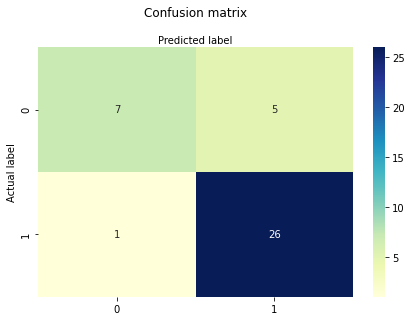

In [55]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



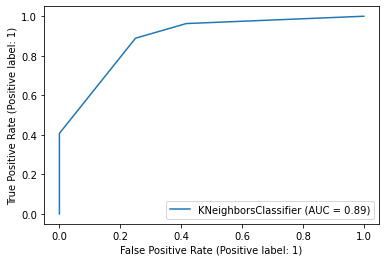

In [56]:
plot_roc_curve(knn_tuned,X_test,y_test)

## KNN

In [57]:
df2 = pd.read_csv('/home/_data/three_groups/combined/combined_drop_na.csv')

In [58]:
df2['Group'] = df2['Diagnosis']
df2['Group'] = df2['Group'].replace('Bipolar I',1)
df2['Group'] = df2['Group'].replace('Bipolar II',1)
df2['Group'] = df2['Group'].replace('MDD',2)
df2['Group'] = df2['Group'].replace('Major Depressive Disorder',2)
df2['Group'] = df2['Group'].replace('Control',0)

df2.columns

Index(['Unnamed: 0.1', 'ID', 'LAMP ID', 'Diagnosis', 'gad_mean', 'gad_var',
       'phq_mean', 'phq_var', 'Group', 'Site', 'Unnamed: 0',
       'gps_data_quality_mean', 'gps_data_quality_var', 'hometime_mean',
       'hometime_var', 'entropy_mean', 'entropy_var', 'internal_sleep_mean',
       'internal_sleep_var'],
      dtype='object')

In [59]:
# predictor and target vars
X2 = df2[['gps_data_quality_mean', 'gps_data_quality_var', 'gad_mean', 'gad_var', 'phq_mean', 'phq_var',
  'hometime_mean', 'hometime_var', 'entropy_mean',
       'entropy_var', 'internal_sleep_mean', 'internal_sleep_var']]
y2 = df2['Group']

In [60]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.4, random_state=0)

In [61]:
# standardize
scale_train = StandardScaler()
scale_test = StandardScaler()

X_train2 = scale_train.fit_transform(X_train2)
X_test2 = scale_test.fit_transform(X_test2)

In [62]:
# Untuned accuracy
knn_basic=KNeighborsClassifier()
knn_basic.fit(X_train2,y_train2)
y_pred2=knn_basic.predict(X_test2)
accuracy_score(y_test2, y_pred2)



0.4117647058823529

In [63]:
knn_clf=KNeighborsClassifier()
leaf_size = list(range(1,10))
n_neighbors = list(range(1,10))
p=[1,2]

# define grid search
grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X2, y2)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.390741 using {'leaf_size': 1, 'n_neighbors': 6, 'p': 1}
0.275926 (0.134836) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 1}
0.275926 (0.134836) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
0.358333 (0.116667) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 1}
0.358333 (0.116667) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 2}
0.300926 (0.099208) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 1}
0.300926 (0.099208) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 2}
0.360185 (0.133263) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 1}
0.360185 (0.133263) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 2}
0.311111 (0.132618) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 1}
0.311111 (0.132618) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 2}
0.390741 (0.101413) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 1}
0.390741 (0.101413) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 2}
0.344444 (0.130408) with: {'leaf_size': 1, 'n_neighbors': 7, 'p': 1}
0.344444 (0.130408) with: {'leaf_size':

In [64]:
params = grid_search.best_params_

In [65]:
knn_tuned = KNeighborsClassifier(leaf_size=params['leaf_size'], 
                                 n_neighbors=params['n_neighbors'], 
                                p=params['p'])
# fit the model with data
knn_tuned.fit(X_train2, y_train2)

y_pred = knn_tuned.predict(X_test2)
cnf_matrix = metrics.confusion_matrix(y_test2, y_pred2)
cnf_matrix

array([[4, 0, 1],
       [2, 0, 4],
       [1, 2, 3]])

In [66]:
y_pred2=knn_tuned.predict(X_test2)
accuracy_score(y_test2, y_pred2)

0.5882352941176471

In [67]:
cnf_matrix

array([[4, 0, 1],
       [2, 0, 4],
       [1, 2, 3]])

In [68]:
index_labels=['Control', 'MDD', 'Bipolar']

cnf_df = pd.DataFrame(cnf_matrix, index=index_labels)
cnf_df.columns = ['Control', 'MDD', 'Bipolar']

Text(33.0, 0.5, 'Actual')

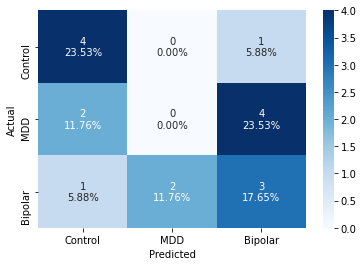

In [69]:
import seaborn as sns

#sns.heatmap(cnf_matrix, annot=True, cmap='Blues')

group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

sns.heatmap(cnf_df, annot=labels, fmt='', cmap='Blues')

plt.xlabel("Predicted")
plt.ylabel("Actual")